## Problem definition and task allocations.

This project aims at detecting failure on the 6 motors of the robot ArmPi FPV from Hiwonder. To do so, we used differents AI model in order to dectect a potential abnormaly. 
As they are 6 motors on the robot, we decided to split the work : 3 persons worked on 2 specifics motors while the last person developped differents preprocessing algorithms that other could try to get better results.  
The data available are position, temperature and voltage for each motors. For the training part, the label is also given. The goal is to predict the label of the 6 motors on the testing dataset given the 3 features of each motors.  
The evaluation is based on F1 score. Indeed, the label class are unbalanced : they are way more class 0 than class with abnormlay. So accuracy isn't relevant : it's very easy to get very good results on accuracy by putting all 0 on the label. With the F1 score, the aim of the project is to have the best model on each of the 6 motors. 

Here is the table of the allocated work from group 2 :

| Member | Task | 
| --- | --- |
| Alix | Preprocessing |
| Come | Motor 1&2|
| Pierre | Motor 3&4 |
| Max | Motor 5&6 |



In [18]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import warnings
from scipy.signal import butter, filtfilt


from util import read_all_test_data_from_path
from utility import extract_selected_feature, prepare_sliding_window, run_cv_one_motor, FaultDetectReg

# Preprocessing

In [20]:
# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  

def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # # Make sure that the difference between the current and previous temperature cannot be too large.
    # # Define your threshold
    # threshold = 10
    # # Shift the 'temperature' column by one row to get the previous temperature
    # prev_tmp = df['temperature'].shift(1)
    # # Calculate the absolute difference between current and previous temperature
    # temp_diff = np.abs(df['temperature'] - prev_tmp)
    # # Set the temperature to NaN where the difference is larger than the threshold
    # df.loc[temp_diff > threshold, 'temperature'] = np.nan
    # df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()

def cal_diff(df: pd.DataFrame, n_int: int = 20):
    ''' # Description
    Calculate the difference between the current and previous n data point.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]

    # Calculate the difference between the current and previous n data point.
    # df['temperature_diff'] = df['temperature'].diff(n_int)
    # df['voltage_diff'] = df['voltage'].diff(n_int)
    # df['position_diff'] = df['position'].diff(n_int)    

def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df)

## Reading the data

### Read the training data

In [21]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Read the training dataset and preprocess
base_dictionary = 'dataset/training_data/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

### Read the testing data.

In [4]:
# Read all the testing dataset with preprocessing
base_dictionary = 'dataset/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [5]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']

# Data analysis

### Violin plot 

In [25]:
sns.set(style="whitegrid")

num_rows = 6

plt.figure(figsize=(20, num_rows * 5))  

def violin_plt(label):

    for i in range(1, 7):
        position_feature = f"data_motor_{i}_position"
        temperature_feature = f"data_motor_{i}_temperature"
        voltage_feature = f"data_motor_{i}_voltage"
        label_feature = f"data_motor_{label}_label"

        plt.subplot(num_rows, 3, (i-1)*3 + 1)
        sns.violinplot(y=position_feature, data=df_train, inner='quartile', hue=label_feature, split=True)
        plt.title('Violin Plot of {}'.format(position_feature))
        plt.ylabel(position_feature)

        plt.subplot(num_rows, 3, (i-1)*3 + 2)
        sns.violinplot(y=temperature_feature, data=df_train, inner='quartile', hue=label_feature, split=True)
        plt.title('Violin Plot of {}'.format(temperature_feature))
        plt.ylabel(temperature_feature)

        plt.subplot(num_rows, 3, (i-1)*3 + 3)
        sns.violinplot(y=voltage_feature, data=df_train, inner='quartile', hue=label_feature, split= True)
        plt.title('Violin Plot of {}'.format(voltage_feature))
        plt.ylabel(voltage_feature)

    plt.tight_layout()
    plt.show()

<Figure size 2000x3000 with 0 Axes>

In [ ]:
violin_plt(1)

In [ ]:
violin_plt(2)

In [ ]:
violin_plt(3)

In [ ]:
violin_plt(4)

In [ ]:
violin_plt(5)

In [ ]:
violin_plt(6)

### Correlation matrix

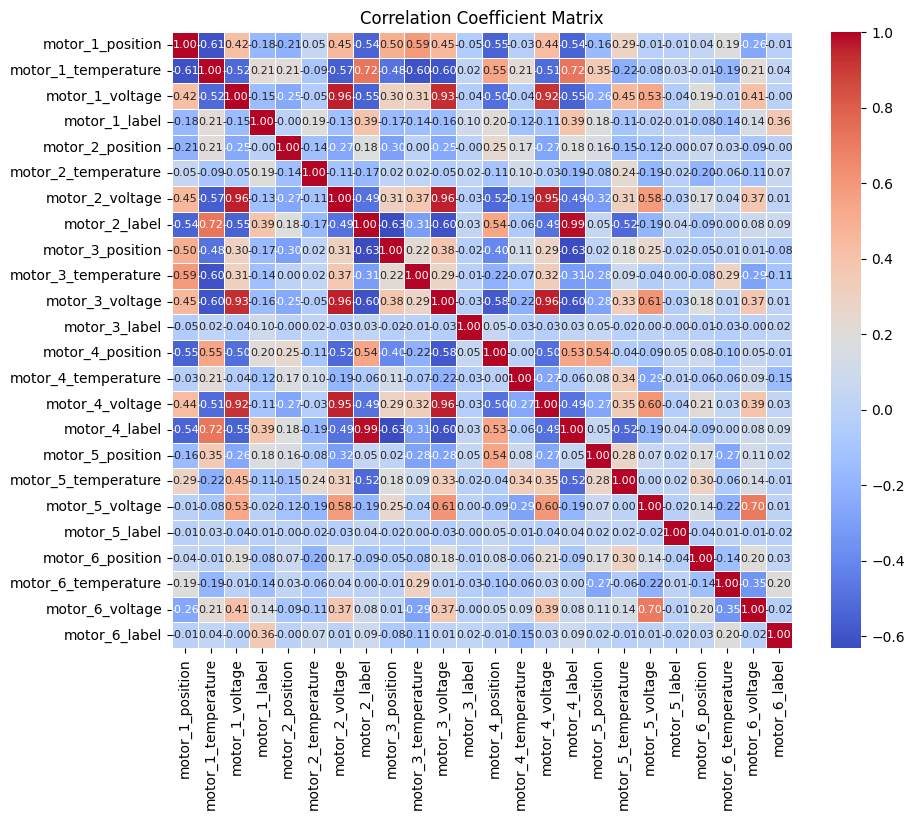

In [8]:
col_to_plot = [col for col in df_train.columns if ('diff' not in col and 'time' not in col and 'test' not in col)]

df_matrix = df_train.loc[:, col_to_plot]

correlation_matrix = df_matrix.corr()

correlation_matrix.columns = [col[5:] for col in correlation_matrix.columns]
correlation_matrix.index = [index[5:] for index in correlation_matrix.index]

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})

plt.title('Correlation Coefficient Matrix')
plt.show()

# Motor 1

On this motor, we chose 5 relevants features : 
- motor 1 temperature and position
- motor 2 temperature
- motor 3 temperature 
- motor 4 temperature  

The best result we got on the testing dataset is a 0.767 f1 score with a random forest classificator with classical parameters (n_estiamtors = 100).  

We prepared a window slide with parameters : 
- window_size = 100
- sample = 2

We trained the model on all the training dataset available 


In [ ]:
motor_idx = 1

df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train+ moving_one_motor_train)]


feature_list_motor1 = ['data_motor_1_temperature', 'data_motor_1_position', 
                       'data_motor_2_temperature',
                        'data_motor_3_temperature',
                        'data_motor_4_temperature'
                       ]

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor1, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 100
sample_step = 2
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

steps = [
    ('standardizer', StandardScaler()), 
    ('mdl', RandomForestClassifier(class_weight='balanced') )  
]
pipeline = Pipeline(steps)
param_grid = {
    'mdl__n_estimators': [100]  # Inverse of regularization strength
}

model1 = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
model1.fit(X_train, y_train)


feature_list_motor1 += ['test_condition']
df_test_x = df_test[feature_list_motor1]
# Augument the features in the same way as the training data.
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')

y_pred_1 = model1.predict(X_test)

# Motor 2 

This motor was a bit harder to get good results and we only managed to get a 0.33 f1 score on the testing dataset.  
To accomplish this, we used a LogisticRegression model with classic parametres (C=1).  
We decided to put a window size of 50 with a sample step of 2. 

The features we selected thanks to the correlation matrix and with a few tries were as follow : 
- motor 1 temperature
- motor 2 temperature and position
- motor 3 temperature
- motor 4 position

We trained this model on the pick up and place training and on the not moving training datasets as it gets better results than training on the whole dataset.

In [ ]:
motor_idx = 2

df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train)]


feature_list_motor2 = ['data_motor_1_temperature',
                       'data_motor_4_position', 
                       'data_motor_2_temperature', 'data_motor_2_position',
                       'data_motor_3_temperature'
                       ]

# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor2, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 50
sample_step = 2
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced') )   # Step 2: Linear Regression
]
param_grid = {
    'mdl__C': [1]  # Inverse of regularization strength
}
# Create the pipeline
pipeline = Pipeline(steps)

model2 = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
model2.fit(X_train, y_train)
feature_list_motor2 += ['test_condition']

df_test_x = df_test[feature_list_motor2]
# Augument the features in the same way as the training data.
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')

y_pred_2 = model2.predict(X_test)

KeyboardInterrupt: 

# Motor 3

As we can see on the correlation matrix, the label of motor 3 seems to be correlated with none of the features. It was the most difficult motor to train.  

The best result we got was a 0.268 f1-score on the testing dataset.  

For that we trained a LogisticRegression (C=0.01) model on the whole dataset. We chose a window_size of 100 with a sample_step of 20.  
The feature selection played a crucial role on the result. We tried a lot of differents combinations using the plot of the training dataset to see manually which features could be relevant to detect abnormaly. 

Surprisingly, none of the combinations we tried worked well and the best results was with using :
- data motor 3 temperature and position



In [ ]:
motor_idx = 3

df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_motor_mixed_train)]


feature_list_motor3 = ['data_motor_3_position', 'data_motor_3_temperature']


# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor3, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 100
sample_step = 50
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced') )   # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# # Define hyperparameters to search
param_grid = {
    'mdl__C': [0.01, 1 , 100],  # Regularization parameter
}

# # Initialize GridSearchCV
model3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)
model3.fit(X_train, y_train)
# # Get the features.
feature_list_motor3 += ['test_condition']

df_test_x = df_test[feature_list_motor3]
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')

y_pred_3 = model3.predict(X_test)


{'mdl__C': 1} 0.09101967799642219


# Motor 4

On this motor we used the 5 relevants features : 
- motor 1,3,4 and 6 temperature
- motor 4 position

Combined with a logistic regression (C = 1) model and a window_size of 100 / sample_step of 5 and a training on the not moving/pick_up_and_place dataset, the model got a 0.49 f1 score on the public testing dataset. 

In [ ]:
motor_idx = 4

df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train)]


feature_list_motor4 = ['data_motor_1_temperature',
                       'data_motor_3_temperature',
                       'data_motor_4_temperature', 'data_motor_4_position',
                       'data_motor_6_temperature']

df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor4, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 100
sample_step = 5

X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

# Define the classification model.
# Define the steps of the pipeline

steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced') )   # Step 2: Linear Regression
]

# Create the pipeline
model4 = Pipeline(steps)

# # Define hyperparameters to search
param_grid = {
    'mdl__C': [1]  # Inverse of regularization strength
}

model4 = GridSearchCV(estimator=model4 , param_grid=param_grid, scoring='f1', cv=5)
model4.fit(X_train, y_train)

feature_list_motor4 += ['test_condition']
df_test_x = df_test[feature_list_motor4]

X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')
y_pred_4 = model4.predict(X_test)

# Motor 5

0.85 Rdf n =100, window=100/5

As shown by the correlation matrix, this motor seems to have the same problem as the motor 3 : none of the features seems to be correlated to motor 5 label. 

But surprisingly, we got a 0.85 f1 score using a random forest classificator (n_estimators = 100) trained on the not moving + moving differents motor part from the training dataset.  
We used :
- motor 1,2, 5 and 6 temperature
- motor 5 position
with a window size of 100 and a sample step of 5.

In [ ]:
motor_idx = 5

df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + moving_motor_mixed_train)]

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', RandomForestClassifier(class_weight='balanced'))   
]

# Create the pipeline
model5 = Pipeline(steps)

# Define hyperparameters to search
param_grid_5 = {
    'mdl__n_estimators': [100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
model5 = GridSearchCV(estimator=model5, param_grid=param_grid_5, scoring='f1', cv=5)

feature_list_motor5 = ['data_motor_1_temperature',
                        'data_motor_2_temperature',
                        'data_motor_5_temperature', 'data_motor_5_position',
                        'data_motor_6_temperature'
                    ]

df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor5, motor_idx = 5, mdl_type='clf')
window_size = 100
sample_step = 5
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')

model5.fit(X_train, y_train)

# Get the features.
feature_list_motor5 = feature_list_motor5 + ['test_condition']

df_test_x = df_test[feature_list_motor5]
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')


y_pred_5 = model5.predict(X_test)

0.49960631596867555


# Motor 6

And finally, the motor 6 got a 0.337 f1-score on the testing dataset. 
To do that we trained on the whole training dataset, used a random forest classifier (n = 500) and a window, sample step of 100 and 10 respectively.  
Here are the 4 features we selected :
- motor 1 temperature
- motor 4 position
- motor 6 temperature
- motor 6 position

In [ ]:
motor_idx = 6

df_data_experiment = df_train[df_train['test_condition'].isin(not_moving_train + pickup_and_place_train + moving_one_motor_train)]

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', RandomForestClassifier(class_weight='balanced'))    
]

# Create the pipeline
model6 = Pipeline(steps)

# Define hyperparameters to search
param_grid_6 = {
    'mdl__n_estimators': [500]  # Inverse of regularization strength
}

# Initialize GridSearchCV
# grid_search_6 = GridSearchCV(estimator=pipeline, param_grid=param_grid_6, scoring='f1', cv=5)
feature_list_motor6 = ['data_motor_1_temperature',
                    'data_motor_4_position',
                    'data_motor_6_temperature', 'data_motor_6_position']

df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_motor6, motor_idx = 6, mdl_type='clf')
window_size = 100
sample_step = 10
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')


model6.fit(X_train, y_train)

# Get the features.
feature_list_motor6 = feature_list_motor6 + ['test_condition']
df_test_x = df_test[feature_list_motor6]
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')

y_pred_6 = model6.predict(X_test)

# Prediction.

In this section, put the code of prediction here. In the end, please output a variable `y_pred_6`, containing the results of the prediction on motor 1.

## Prepare the results as a submission file for the data challenge.

In this section, we demo how to prepare the results as a submission file for the data challenge. First, we need to download the submission template `sample_submission.csv` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data). As shown below, in this csv files, we just need to give our prediction on the six motors in the corresponding columns. You can find a demo below.

In [ ]:
import pandas as pd

# Read the template.
path = 'dataset/sample_solution.csv' # Change to your path.
df_submission = pd.read_csv(path)

# Initial all values with -1.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']] = -1
df_submission.head()

,idx,data_motor_1_label,data_motor_2_label,data_motor_3_label,data_motor_4_label,data_motor_5_label,data_motor_6_label
0,0,-1,-1,-1,-1,-1,-1
1,1,-1,-1,-1,-1,-1,-1
2,2,-1,-1,-1,-1,-1,-1
3,3,-1,-1,-1,-1,-1,-1
4,4,-1,-1,-1,-1,-1,-1


In [ ]:
# Replace each column with your prediction.
df_submission['data_motor_1_label'] = y_pred_1
df_submission['data_motor_2_label'] = y_pred_2
df_submission['data_motor_3_label'] = y_pred_3
df_submission['data_motor_4_label'] = y_pred_4
df_submission['data_motor_5_label'] = y_pred_5
df_submission['data_motor_6_label'] = y_pred_6

In [ ]:
# Output the submission csv.
df_submission.to_csv('results/submission.csv')